In [1]:
import os

# Crear carpetas
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/test_users", exist_ok=True)
os.makedirs("data/groups", exist_ok=True)

print("📂 Carpetas creadas")

# URL base del repo oficial de la materia
BASE = "https://raw.githubusercontent.com/DiploDatos/AprendizajePorRefuerzos/master/tp_decision_transformer/data"

# TRAIN
train_files = [
    "train/netflix8_train.df",
    "train/netflixM8_train.df",
    "train/goodreads8_train.df",
]

for f in train_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    !wget -q "{url}" -O "{dest}"
print("✔️ Train descargado.")

# TEST USERS
test_files = [
    "test_users/netflix8_test.json",
    "test_users/goodreads8_test.json",
]

for f in test_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    !wget -q "{url}" -O "{dest}"
print("✔️ Test users descargado.")

# GROUPS
groups_files = [
    "groups/mu_goodreads8.csv",
    "groups/mu_netflix8.csv",
    "groups/mu_netflixM8.csv",
]

for f in groups_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    !wget -q "{url}" -O "{dest}"
print("✔️ Groups descargado.")

print("\n📁 CONTENIDO FINAL:")
!ls -R data


📂 Carpetas creadas
⬇️  Descargando train/netflix8_train.df ...
⬇️  Descargando train/netflixM8_train.df ...
⬇️  Descargando train/goodreads8_train.df ...
✔️ Train descargado.
⬇️  Descargando test_users/netflix8_test.json ...
⬇️  Descargando test_users/goodreads8_test.json ...
✔️ Test users descargado.
⬇️  Descargando groups/mu_goodreads8.csv ...
⬇️  Descargando groups/mu_netflix8.csv ...
⬇️  Descargando groups/mu_netflixM8.csv ...
✔️ Groups descargado.

📁 CONTENIDO FINAL:
data:
groups	test_users  train

data/groups:
mu_goodreads8.csv  mu_netflix8.csv  mu_netflixM8.csv

data/test_users:
goodreads8_test.json  netflix8_test.json

data/train:
goodreads8_train.df  netflix8_train.df	netflixM8_train.df


In [2]:
!rm -rf Ferreyra_Tomas_tp_dt
!git clone https://github.com/tferreyragthb/Ferreyra_Tomas_tp_dt.git

import sys
repo_path = "/content/Ferreyra_Tomas_tp_dt"
if repo_path not in sys.path:
    sys.path.append(repo_path)

print("📚 Repo cargado:", repo_path)


Cloning into 'Ferreyra_Tomas_tp_dt'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 274 (delta 9), reused 0 (delta 0), pack-reused 236 (from 1)
Receiving objects: 100% (274/274), 15.83 MiB | 15.95 MiB/s, done.
Resolving deltas: 100% (64/64), done.
📚 Repo cargado: /content/Ferreyra_Tomas_tp_dt


In [3]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from src.data.dataset import RecommendationDataset
from src.models.decision_transformer import DecisionTransformer
from src.training.trainer import train_decision_transformer


In [4]:
!mkdir -p data/processed

# === Descargar ZIP correcto desde tu repo ===
!wget -q \
  https://raw.githubusercontent.com/tferreyragthb/Ferreyra_Tomas_tp_dt/main/src/data/processed/netflix_trajectories_train.zip \
  -O data/processed/netflix_trajectories_train.zip

print("Contenido de data/processed después de descargar ZIP:")
!ls -lh data/processed

# === Descomprimir ===
!unzip -o data/processed/netflix_trajectories_train.zip -d data/processed/

print("Contenido de data/processed después de descomprimir:")
!ls -lh data/processed


Contenido de data/processed después de descargar ZIP:
total 8.2M
-rw-r--r-- 1 root root 8.2M Dec  8 20:29 netflix_trajectories_train.zip
Archive:  data/processed/netflix_trajectories_train.zip
  inflating: data/processed/data/processed/netflix_trajectories_train.pkl  
Contenido de data/processed después de descomprimir:
total 8.2M
drwxr-xr-x 3 root root 4.0K Dec  8 20:29 data
-rw-r--r-- 1 root root 8.2M Dec  8 20:29 netflix_trajectories_train.zip


In [5]:
# mover el archivo a la ubicación correcta
!mv data/processed/data/processed/netflix_trajectories_train.pkl data/processed/

# borrar carpeta extra
!rm -rf data/processed/data

print("Archivos actuales:")
!ls -lh data/processed


Archivos actuales:
total 52M
-rw-r--r-- 1 root root  44M Dec  8 19:50 netflix_trajectories_train.pkl
-rw-r--r-- 1 root root 8.2M Dec  8 20:29 netflix_trajectories_train.zip


In [6]:
import pickle

DATASET = "netflix"
pkl_path = f"data/processed/{DATASET}_trajectories_train.pkl"

with open(pkl_path, "rb") as f:
    trajectories_train = pickle.load(f)

print(f"Trayectorias cargadas: {len(trajectories_train)}")


Trayectorias cargadas: 16000


In [7]:
from torch.utils.data import DataLoader
from src.data.dataset import RecommendationDataset

context_length = 20
batch_size = 32

train_dataset = RecommendationDataset(
    trajectories=trajectories_train,
    context_length=context_length,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
for k, v in batch.items():
    print(k, v.shape)


Batch keys: dict_keys(['states', 'actions', 'rtg', 'timesteps', 'groups', 'targets'])
states torch.Size([32, 20])
actions torch.Size([32, 20])
rtg torch.Size([32, 20, 1])
timesteps torch.Size([32, 20])
groups torch.Size([32])
targets torch.Size([32, 20])


In [8]:
import torch
from src.models.decision_transformer import DecisionTransformer

# detectar device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# cantidad de ítems y grupos reales del dataset
num_items = max([traj["items"].max() for traj in trajectories_train]) + 1
num_groups = max([traj["user_group"] for traj in trajectories_train]) + 1

model = DecisionTransformer(
    num_items=num_items,
    num_groups=num_groups,
    context_length=context_length,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Modelo y optimizer listos.")


Device: cuda
Modelo y optimizer listos.


Epoch 1/10, Loss: 6.6249
Epoch 2/10, Loss: 6.6238
Epoch 3/10, Loss: 6.6239
Epoch 4/10, Loss: 6.6236
Epoch 5/10, Loss: 6.6235
Epoch 6/10, Loss: 6.6234
Epoch 7/10, Loss: 6.6234
Epoch 8/10, Loss: 6.6232
Epoch 9/10, Loss: 6.6231
Epoch 10/10, Loss: 6.6232


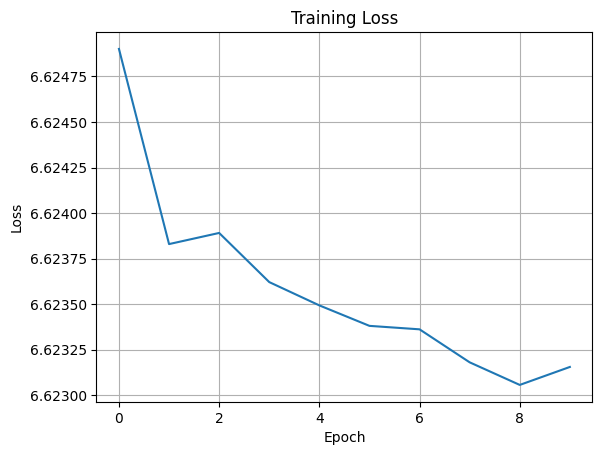

In [9]:
from src.training.trainer import train_decision_transformer
import matplotlib.pyplot as plt

num_epochs = 10

model, history = train_decision_transformer(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
)

plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()


In [10]:
import os
os.makedirs("results/checkpoints", exist_ok=True)

save_path = "results/checkpoints/dt_model.pth"
torch.save(model.state_dict(), save_path)

print("Modelo guardado en:", save_path)


Modelo guardado en: results/checkpoints/dt_model.pth


In [11]:
from google.colab import files
import os

ckpt_path = "results/checkpoints/dt_model.pth"

if os.path.exists(ckpt_path):
    print(f"Encontrado: {ckpt_path} — Tamaño: {os.path.getsize(ckpt_path)/1024:.1f} KB")
    files.download(ckpt_path)
else:
    print("❌ No se encontró el checkpoint en results/checkpoints/dt_model.pth")


Encontrado: results/checkpoints/dt_model.pth — Tamaño: 3266.2 KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>